In [195]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline                               

from glob import glob
from keras.backend.tensorflow_backend import set_session
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, image
from keras.optimizers import SGD

In [226]:
TRAINING_DIR = 'data/data_new/'
IMAGE_SIZE = 64
RANDOM_STATE = 15
BATCH_SIZE = 20

PIECE_NAMES = [item[14:] for item in sorted(glob(TRAINING_DIR + "/*"))]

In [219]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

In [205]:
train_generator = data_generator.flow_from_directory(
    TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=RANDOM_STATE, 
    color_mode='grayscale', class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(
    TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=RANDOM_STATE,
    color_mode='grayscale', class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 909 images belonging to 7 classes.
Found 224 images belonging to 7 classes.


In [212]:
### TODO: Define your architecture.
model = Sequential()
# model.add(ZeroPadding2D((1, 1), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))

# Layer 1
model.add(BatchNormalization(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Layer 2
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Layer 3
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# Layer 4
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))

# Layer 5
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(GlobalMaxPooling2D())
model.add(BatchNormalization())
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_216 (Bat (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization_217 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_218 (Bat (None, 32, 32, 64)        256       
__________

In [213]:
model.compile(loss='categorical_crossentropy', optimizer='adagrad')

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.piece_class.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [214]:
epochs = 25
batch_size = 25

model.fit_generator(
    train_generator,
    steps_per_epoch=909//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps= 224//batch_size,
    callbacks=[checkpointer, early_stopping],
)

Epoch 1/25
36/36 [==============================] - 32s 879ms/step - loss: 3.7188 - val_loss: 1.7023

Epoch 00001: val_loss improved from inf to 1.70232, saving model to saved_models/weights.best.piece_class.hdf5
Epoch 2/25
36/36 [==============================] - 27s 743ms/step - loss: 1.5144 - val_loss: 1.4275

Epoch 00002: val_loss improved from 1.70232 to 1.42746, saving model to saved_models/weights.best.piece_class.hdf5
Epoch 3/25
36/36 [==============================] - 25s 685ms/step - loss: 1.1360 - val_loss: 1.2218

Epoch 00003: val_loss improved from 1.42746 to 1.22176, saving model to saved_models/weights.best.piece_class.hdf5
Epoch 4/25
36/36 [==============================] - 26s 718ms/step - loss: 0.9566 - val_loss: 0.8570

Epoch 00004: val_loss improved from 1.22176 to 0.85702, saving model to saved_models/weights.best.piece_class.hdf5
Epoch 5/25
36/36 [==============================] - 25s 690ms/step - loss: 0.6156 - val_loss: 0.4535

Epoch 00005: val_loss improved fro

In [242]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = image.img_to_array(img)
    x = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x = np.expand_dims(x, axis=2)
    return x.astype('float32')/255

def predict_piece(img_path):
    tensor = path_to_tensor(img_path)
    _x = np.expand_dims(tensor, axis=0)
    return model.predict(_x)

def show_img(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)

    plt.imshow(gray, cmap="gray", vmin=0, vmax=255)
    plt.show()

def predict_arr(arr):
    from PIL import Image
    img = Image.fromarray(arr)
    x = img.resize((256, 256))
    x = np.expand_dims(x, axis=2)
    x = x.astype('float32')/255
    x = np.expand_dims(x, axis=0)
    return model.predict(_x)

In [243]:
model.load_weights('saved_models/weights.best.piece_class.hdf5')

In [244]:
PIECE_NAMES

['BISHOP', 'BLANK', 'KING', 'KNIGHT', 'PAWN', 'QUEEN', 'ROOK']

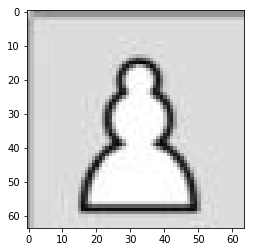

PAWN


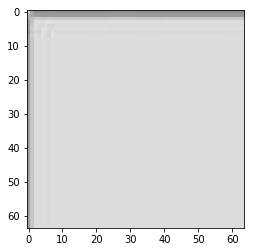

BLANK


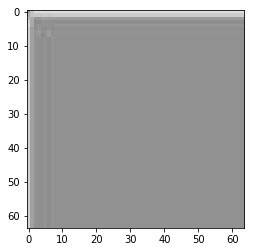

BLANK


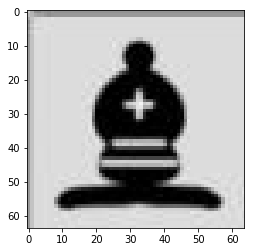

BISHOP


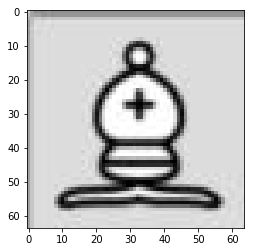

BISHOP


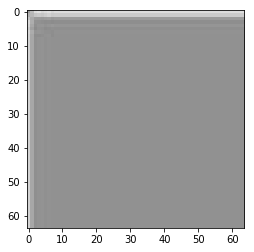

BLANK


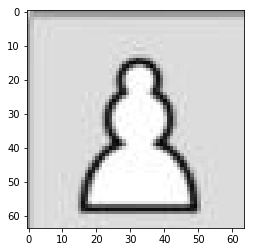

PAWN


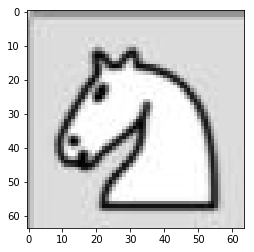

KNIGHT


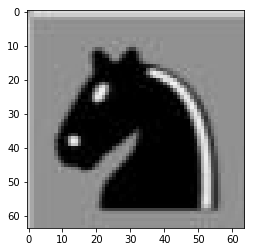

KNIGHT


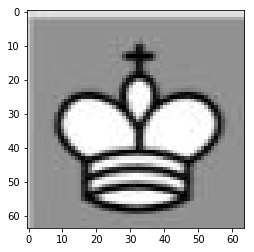

KING


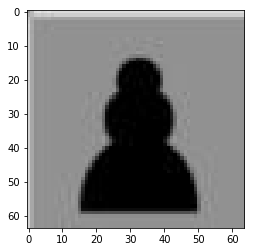

PAWN


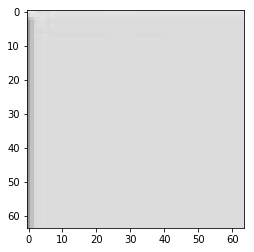

BLANK


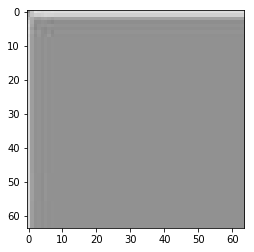

BLANK


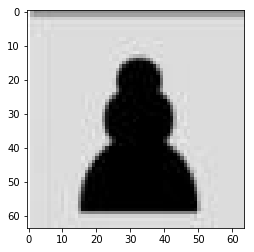

PAWN


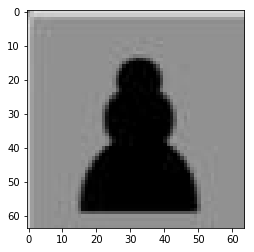

PAWN


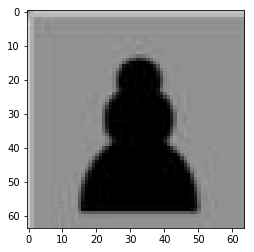

PAWN


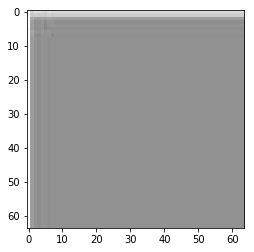

BLANK


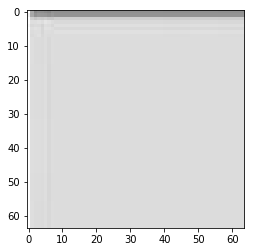

BLANK


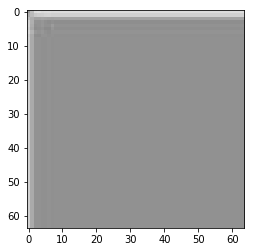

BLANK


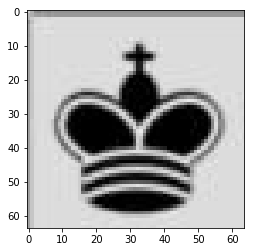

KING


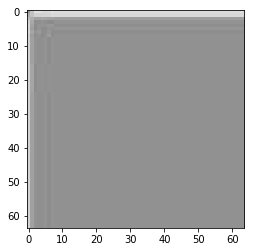

BLANK


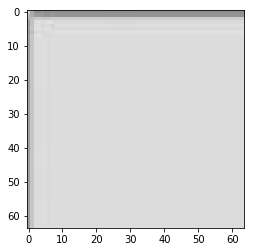

BLANK


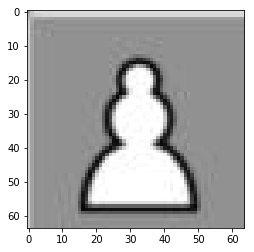

PAWN


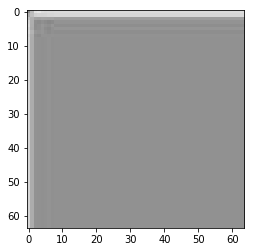

BLANK


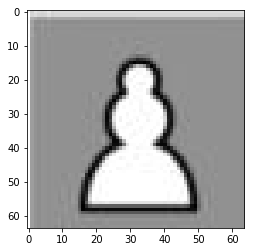

PAWN


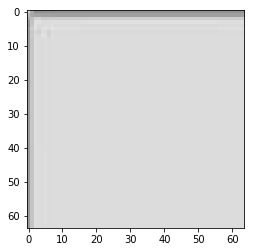

BLANK


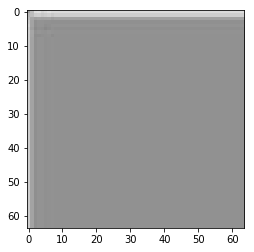

BLANK


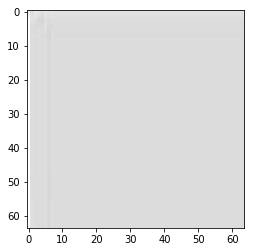

BLANK


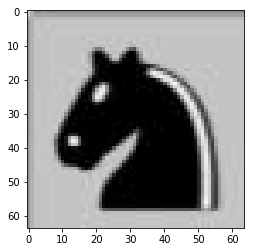

KNIGHT


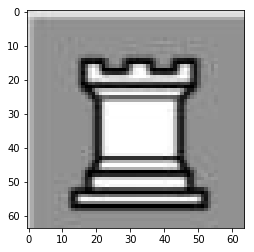

ROOK


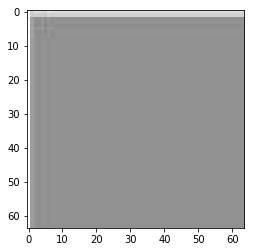

BLANK


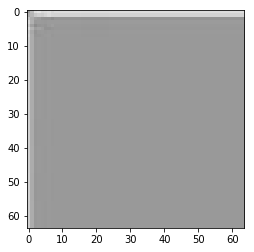

BLANK


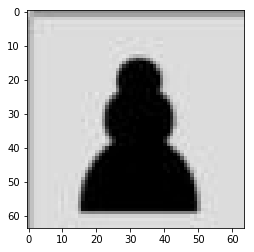

PAWN


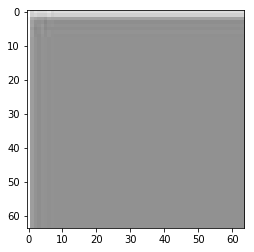

BLANK


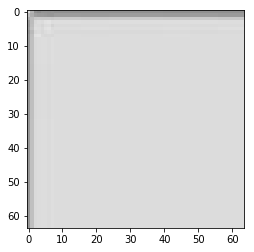

BLANK


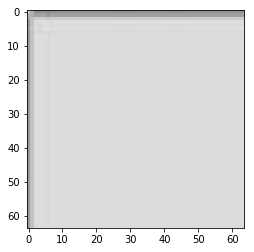

BLANK


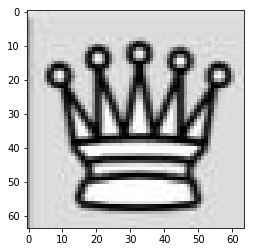

QUEEN


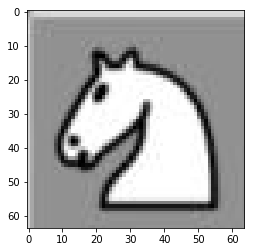

KNIGHT


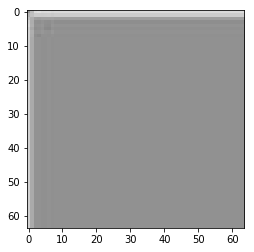

BLANK


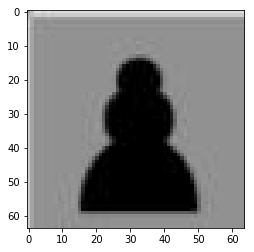

PAWN


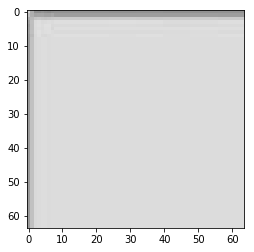

BLANK


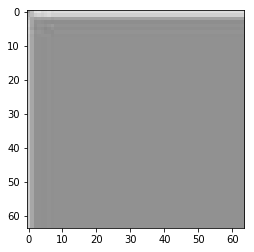

BLANK


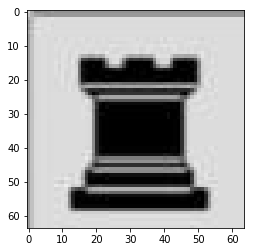

ROOK


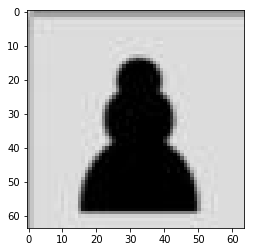

PAWN


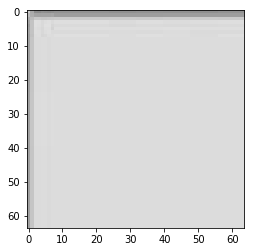

BLANK


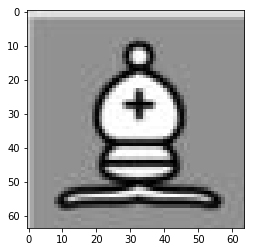

BISHOP


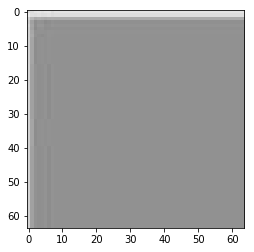

BLANK


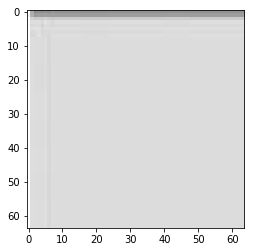

BLANK


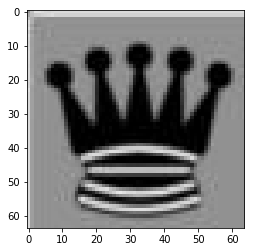

QUEEN


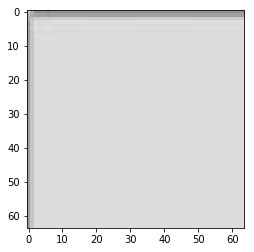

BLANK


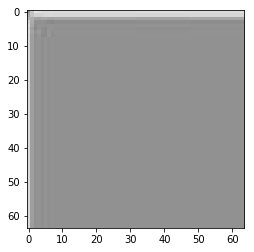

BLANK


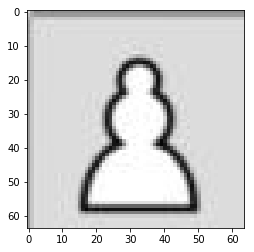

PAWN


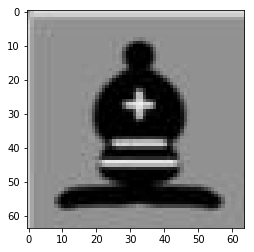

BISHOP


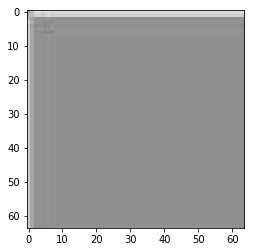

BLANK


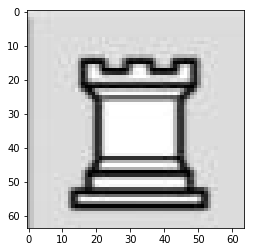

ROOK


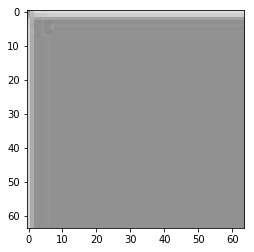

BLANK


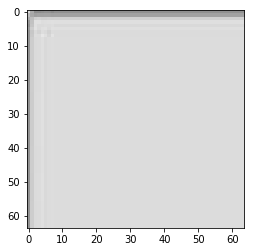

BLANK


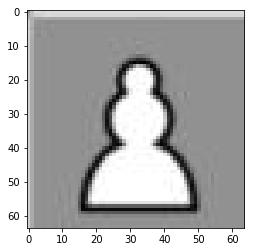

PAWN


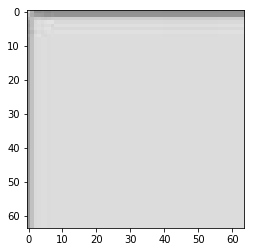

BLANK


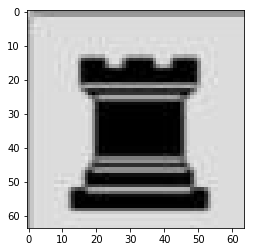

ROOK


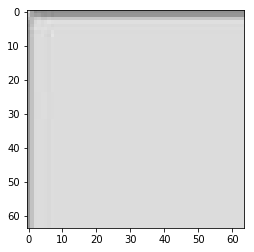

BLANK


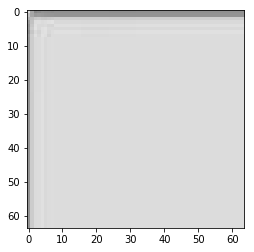

BLANK


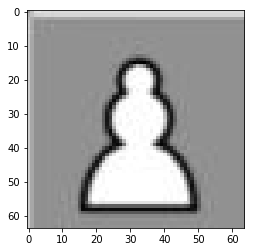

PAWN


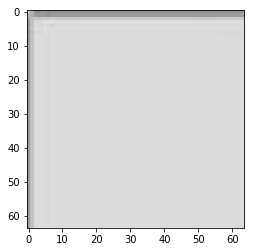

BLANK


In [246]:
test = glob('data/chess_pieces_test/*')
for img in test:
    show_img(img)
    print(PIECE_NAMES[np.argmax(predict_piece(img))])
# array([[0.02215751, 0.02012262, 0.0809833 , 0.747563  , 0.04251623,
#         0.08665736]], dtype=float32)